# 3D analysis

In this tutorial, we present the basics steps for a 3D stacked analysis. The main aim is to perform a spectral and morphological analysis of a given source.
We are going to analyze a generic Galactic field of the internal Science Data Challenge of CTAO. The field is rich of sources, with growing complexity of their spectral and spatial properties.

Let's start with some basic imports:

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.datasets import MapDataset, Datasets
from gammapy.data import (
    DataStore,
    Observation,
    Observations,
)
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.makers import (
    MapDatasetMaker, 
    SafeMaskMaker, 
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models,
)

Let's investigate the Galactic field centered at the coordinates l, b = 341.90669676°, -3.62457011°. We select all the available observations inside a cone of radius 5°.

In [2]:
# if neede, set the path of the IRFs:
#%env CALDB=../caldb/

In [3]:
data_store = DataStore.from_dir("../CTA-SDC")

In [4]:
#pointing coordinates
l, b = 341.90669676 * u.deg, -3.62457011 * u.deg 
pointing = SkyCoord(l, b, frame="galactic")

In [5]:
selection = dict(
    type="sky_circle",
    frame="galactic",
    lon=pointing.galactic.l.deg,
    lat=pointing.galactic.b.deg,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [6]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])
len(observations)

37

In [7]:
print(observations[0])

Observation

	obs id            : 5000002225 
 	tstart            : 61884.22
	tstop             : 61884.24
	duration          : 1575.00 s
	pointing (icrs)   : 255.2 deg, -43.8 deg

	deadtime fraction : 0.0%



In [8]:
observations[0].events

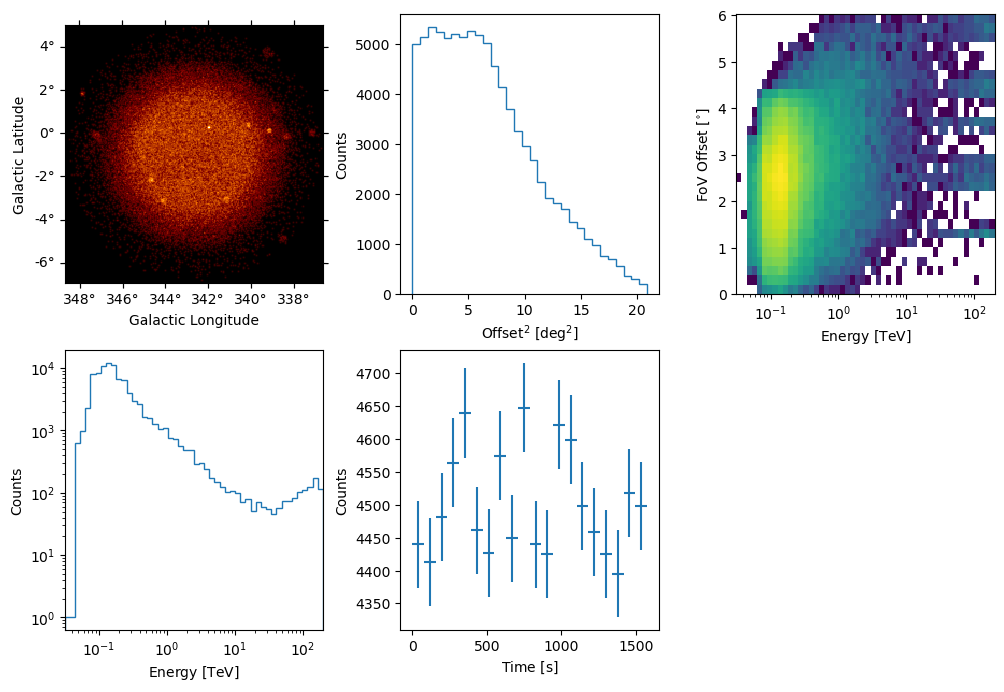

In [9]:
observations[0].events.peek()

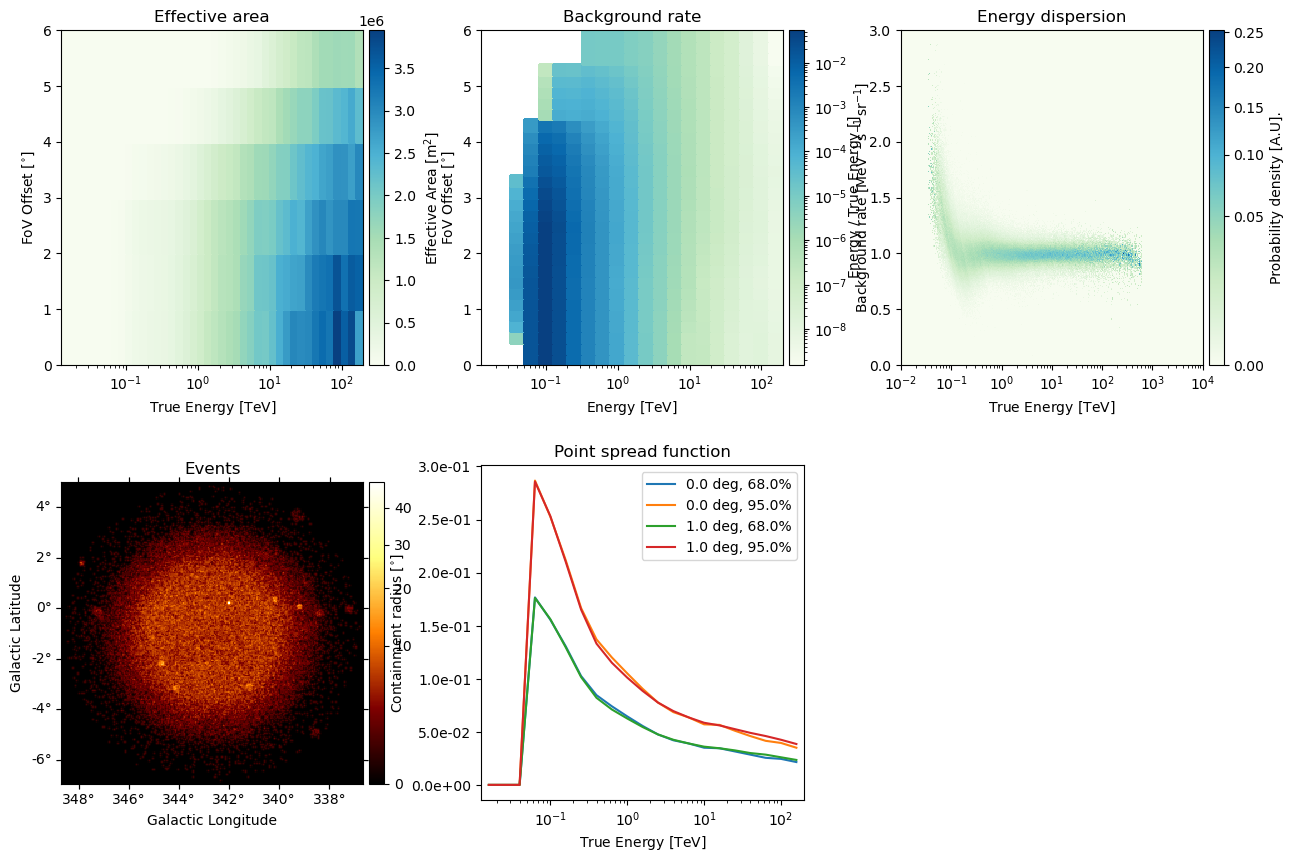

In [10]:
observations[0].peek()

Now, we generate the 'stacked' dataset:

In [11]:
# Create the reconstruced energy range:
energy_axis = MapAxis.from_energy_bounds(0.03, 199.0, 8, unit="TeV")

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.001, 250, 10, unit="TeV", name="energy_true"
)


geom = WcsGeom.create(
    skydir=(pointing.galactic.l.deg , pointing.galactic.b.deg),
    binsz=0.01,
    width=(5, 5),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

In [12]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
)

A number of sources is present in the field. This can affect significantly the estimates of the background and it implies therefore that we need to exclude these regions from the data, applying a mask. The source regions can be choosen manually or, more likely, from catalogues of known sources:

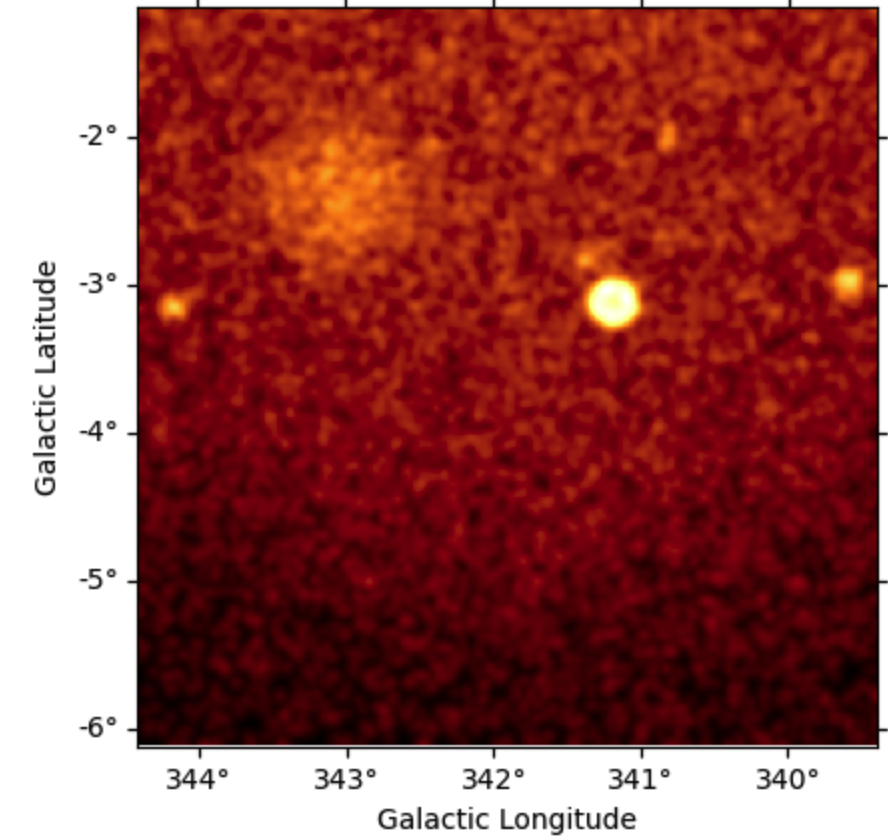

In [13]:
maker_fov = FoVBackgroundMaker(method="fit")

In [14]:
offset_max = 5 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], aeff_percent=10, offset_max=offset_max
)

In [15]:
# we just take the first 15 obervations to speed up the analysis:
obs_selection = observations[:15]
for i, obs in enumerate(obs_selection):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width= 2.5 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(obs_selection)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 15, Background norm obs 5000002225: 1.50
1 of 15, Background norm obs 5000002226: 1.46
2 of 15, Background norm obs 5000002250: 1.30
3 of 15, Background norm obs 5000002251: 1.24
4 of 15, Background norm obs 5000002280: 1.45
5 of 15, Background norm obs 5000002307: 1.38
6 of 15, Background norm obs 5000002308: 1.78
7 of 15, Background norm obs 5000002404: 1.30
8 of 15, Background norm obs 5000002405: 1.22
9 of 15, Background norm obs 5000002436: 1.56
10 of 15, Background norm obs 5000002437: 1.61
11 of 15, Background norm obs 5000002459: 1.23
12 of 15, Background norm obs 5000002461: 1.42
13 of 15, Background norm obs 5000002635: 1.42
14 of 15, Background norm obs 5000002636: 1.93
MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 8378 
  Total background counts         : 8377.73
  Total excess counts             : 0.27

  Predicted counts                : 8377.73
  Predicted background counts     : 8377.73
  Predicted exces

Let's inspect the field:

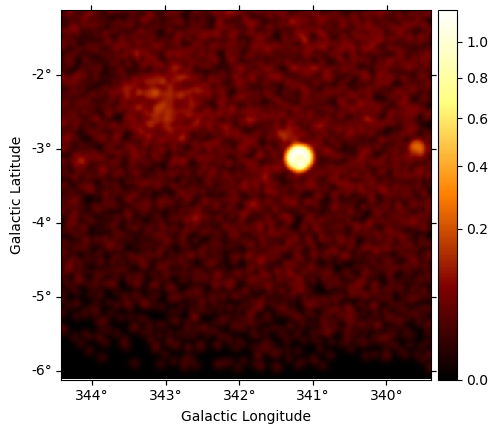

In [16]:
stacked.counts.sum_over_axes().smooth(0.04 * u.deg).plot(stretch="sqrt", add_cbar=True)

plt.show()

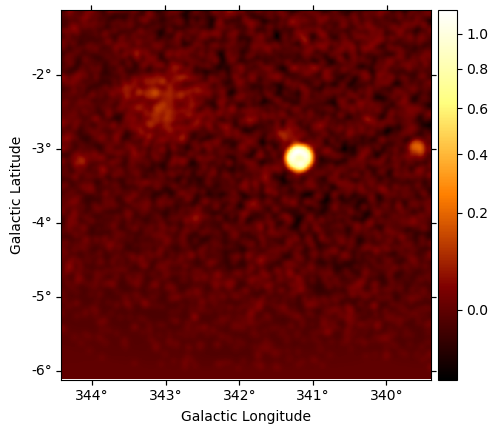

In [17]:
excess = stacked.excess.sum_over_axes()
excess.smooth("0.04 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

# Exclusion masks:
Let's estimate with major accuracy the background, ignoring the regions where bright sources are clearly visible. We can create a TS map and run a source detection in order to determine the source positions (see Gammapy tutorial at https://docs.gammapy.org/1.2/tutorials/analysis-2d/detect.html):

In [18]:
# define a spatial model
spatial_model = PointSpatialModel()

# Define a spectral model;
# (We choose units consistent with the map units here...)
spectral_model = PowerLawSpectralModel(amplitude="1e-12 cm-2 s-1 TeV-1", index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

estimator = TSMapEstimator(
    model,
    kernel_width="0.3 deg",
    energy_edges=[0.03, 20] * u.TeV,
)
maps = estimator.run(stacked)

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
8.7975,482,312,254.71789,-47.47020
6.3971,126,386,256.98554,-44.19547
6.2673,132,364,257.18234,-44.37477
6.183,318,305,256.26739,-46.21673
4.9049,145,384,256.84935,-44.35971
4.6127,26,294,258.83923,-43.92740
4.4207,301,329,256.14029,-45.93616
4.3215,161,383,256.72639,-44.49377


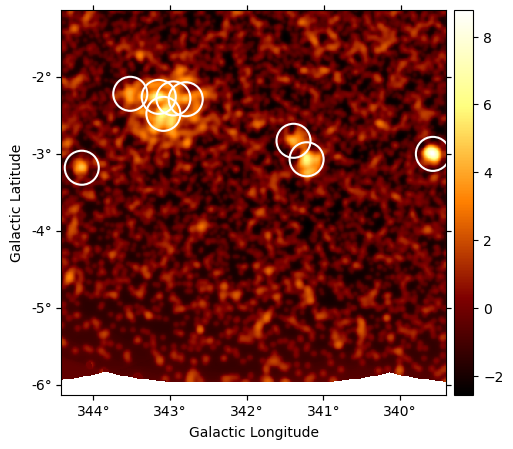

In [27]:
# change these settings as you wish
sources = find_peaks(maps["sqrt_ts"], threshold=4, min_distance="0.1 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=ax.get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

In the example here, the coordinates are converted to the Galactic ones and the exclusion region size is chosen by eye. Please, be aware that some detected sources could be the spots of an extended one:

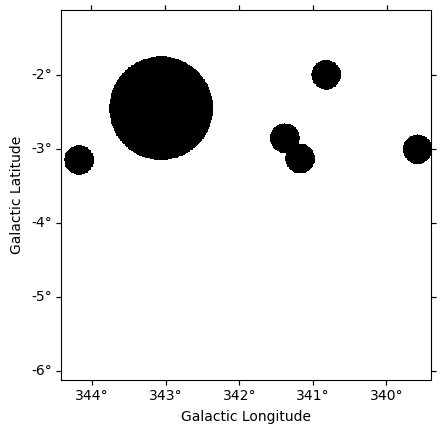

In [28]:
#our source
#SkyCoord(339.58634079, -3.01718097, unit="deg", frame="icrs")

exclusion_src1 = CircleSkyRegion(
    center=SkyCoord(344.1646678, -3.16256952, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src2 = CircleSkyRegion(
    center=SkyCoord(343.05454002, -2.46546336, unit="deg", frame="galactic"),
    radius=0.7 * u.deg,
)
exclusion_src3 = CircleSkyRegion(
    center=SkyCoord(341.17287207, -3.14538304, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src4 = CircleSkyRegion(
    center=SkyCoord(341.38004212, -2.86952312, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src5 = CircleSkyRegion(
    center=SkyCoord(340.82287577, -2.01295808, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)
exclusion_src6 = CircleSkyRegion(
    center=SkyCoord(339.58634079, -3.01718097, unit="deg", frame="galactic"),
    radius=0.2 * u.deg,
)

exclusion_geom = WcsGeom.create(
    npix=(500, 500), binsz=0.01, skydir=pointing.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~exclusion_geom.region_mask([exclusion_src1, exclusion_src2, exclusion_src3,
                                   exclusion_src4, exclusion_src5, exclusion_src6])

exclusion_mask.plot()
plt.show()

Let's create the stacked dataset again:

In [29]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
)

We can now pass the exclusion mask to `FoVBackgroundMaker`:

In [30]:
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [31]:
# we just take the first 15 obervations to speed up the analysis:
obs_selection = observations[:15]
for i, obs in enumerate(obs_selection):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width= 2.5 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(obs_selection)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 15, Background norm obs 5000002225: 1.30
1 of 15, Background norm obs 5000002226: 1.33
2 of 15, Background norm obs 5000002250: 1.15
3 of 15, Background norm obs 5000002251: 1.03
4 of 15, Background norm obs 5000002280: 0.98
5 of 15, Background norm obs 5000002307: 0.96
6 of 15, Background norm obs 5000002308: 1.15
7 of 15, Background norm obs 5000002404: 1.12
8 of 15, Background norm obs 5000002405: 1.07
9 of 15, Background norm obs 5000002436: 0.91
10 of 15, Background norm obs 5000002437: 1.04
11 of 15, Background norm obs 5000002459: 1.09
12 of 15, Background norm obs 5000002461: 0.80
13 of 15, Background norm obs 5000002635: 0.99
14 of 15, Background norm obs 5000002636: 2.15
MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 8378 
  Total background counts         : 6945.00
  Total excess counts             : 1433.00

  Predicted counts                : 6945.00
  Predicted background counts     : 6945.00
  Predicted ex

### Exercise: 
- Create a rectangular region around the Galactic plane to mask the diffuse emission

## 3D analysis of one source

The 3D analysis consists of a simultaneous fit of the spectral and spatial parameters of one or multiple sources. Here, we focus only on a single source, centered at the coordinates l, b = 339.5962°, lat_0=-2.985°. 
To perform the fit, we firstly need to define a model: we can try with a Gaussian morphology and a powerlaw spectral shape:

In [32]:
#spatial_model = PointSpatialModel(
#    lon_0="254.7204743 deg", lat_0="-47.4492570 deg", frame="icrs"
#)
spatial_model = GaussianSpatialModel(
    lon_0="339.59620994 deg", lat_0="-2.98500599 deg", frame="galactic",
    sigma="0.1 deg"
)

spectral_model = PowerLawSpectralModel(
    index=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
)
#spectral_model.amplitude.min = 1e-20
#spectral_model.amplitude.max = 1e-6

#spectral_model = ExpCutoffPowerLawSpectralModel(
#    index=2.0020e+00,
#    amplitude=5.1154e-13 * u.Unit("cm-2 s-1 TeV-1"),
#    reference=1.0 * u.TeV,
#    _lambda = "0.1 TeV-1"
#)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="gc-source",
)

# FOR SIMPLICITY, WE ASSUME THE BACKGROUND IS WELL KNOWN AND CAN BE 
# TAKEN FROM THE IRF BKG MODEL:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)
bkg_model.spectral_model.norm.value = 1.0

models_stacked = Models([model, bkg_model])

stacked.models = models_stacked

Once the model is defined, we can fit the dataset with the Gammapy `Fit` class. This class can be set through a number of parameters which allow you to select the backend ("iminuit", "sherpa", "scipy"), the accuracy of the fit, the speed of the fit and so on...
The "strategy" option changes the speed and accuracy of the optimizer: 0 fast, 1 default, 2 slow but accurate. 
If you want more reliable error estimates, you should run the final fit with strategy 2.

Let's start a fit with iMinuit and default strategy:

In [33]:
stacked.mask_fit = stacked.counts.geom.energy_mask(
    energy_min=0.05 * u.TeV, energy_max=None
)

# For simplicity we might freeze the coordinates:
#stacked.models.parameters["lon_0"].frozen = False
#stacked.models.parameters["lat_0"].frozen = False
stacked.models.parameters["lon_0"].frozen = True
stacked.models.parameters["lat_0"].frozen = True

fit = Fit(store_trace=True)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit.backend = "minuit"
fit.optimize_opts = minuit_opts

result = fit.run(datasets=[stacked])

In [34]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 142
	total stat : 92386.81

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [35]:
display(stacked.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str14,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
gc-source,,index,1.9018e+00,,1.167e-01,nan,nan,False,False,,
gc-source,,amplitude,3.0450e-13,TeV-1 s-1 cm-2,7.284e-14,nan,nan,False,True,,
gc-source,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
gc-source,,lon_0,3.3960e+02,deg,0.000e+00,nan,nan,True,False,,
gc-source,,lat_0,-2.9850e+00,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,,
gc-source,,sigma,4.1393e-02,deg,5.977e-03,0.000e+00,nan,False,False,,
gc-source,,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,,
gc-source,,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,,
my-dataset-bkg,,norm,1.1980e+00,,1.315e-02,nan,nan,False,True,,


In [36]:
display(result.trace)

total_stat,gc-source.spectral.index,gc-source.spectral.amplitude,gc-source.spatial.sigma,my-dataset-bkg.spectral.norm
float64,float64,float64,float64,float64
92713.88051923472,2.0,1e-12,0.09999999999999999,1.0
92697.94111743622,2.148677328798411,1e-12,0.09999999999999999,1.0
92749.73051547469,1.8513226712015893,1e-12,0.09999999999999999,1.0
92711.55716607816,2.014867732879841,1e-12,0.09999999999999999,1.0
92716.39869904275,1.985132267120159,1e-12,0.09999999999999999,1.0
92712.75008151533,2.0070823980819137,1e-12,0.09999999999999999,1.0
92715.05515936049,1.9929176019180863,1e-12,0.09999999999999999,1.0
92734.59941640253,2.0,1.1486773287984107e-12,0.09999999999999999,1.0
...,...,...,...,...


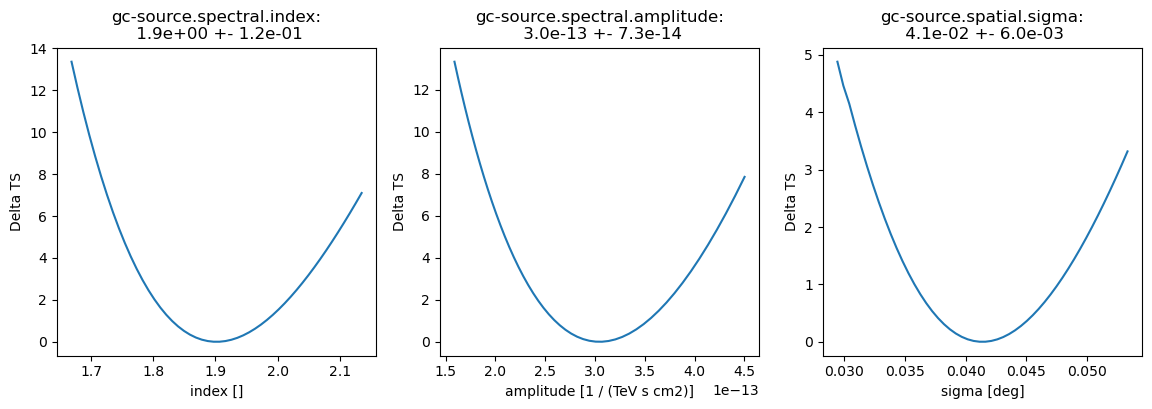

In [37]:
total_stat = result.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, stacked.models[0].parameters.free_parameters):
    par.scan_n_values = 50
    idx = stacked.models[0].parameters.index(par)
    name = stacked.models.parameters_unique_names[idx]
    profile = fit.stat_profile(datasets=stacked, parameter=par)
    ax.plot(profile[f"{name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.name} [{par.unit}]")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{name}:\n {par.value:.1e} +- {par.error:.1e}")
plt.show()

In [38]:
def make_contours(fit, datasets, result, npoints, sigmas):
    from itertools import combinations
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["index", "amplitude", "sigma"], r=2):
            idx1, idx2 = datasets.models[0].parameters.index(par_1), datasets.models[0].parameters.index(
                par_2
            )
            name1 = datasets.models.parameters_unique_names[idx1]
            name2 = datasets.models.parameters_unique_names[idx2]
            contour = fit.stat_contour(
                datasets=datasets,
                x=datasets.models[0].parameters[par_1],
                y=datasets.models[0].parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour[name1].tolist(),
                par_2: contour[name2].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

In [ ]:
sigmas = [1, 2]
cts_sigma = make_contours(
    fit=fit,
    datasets=stacked,
    result=result,
    npoints=20,
    sigmas=sigmas,
)

In [ ]:
pars = {
    "amplitude": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "index": r"$\Gamma$",
    "sigma": r"$\sigma$",
}

panels = [
    {
        "x": "index",
        "y": "amplitude",
        "cx": (lambda ct: ct["contour_index_amplitude"]["index"]),
        "cy": (lambda ct: np.array(1e13) * ct["contour_index_amplitude"]["amplitude"]),
    },
    {
        "x": "sigma",
        "y": "amplitude",
        "cx": (lambda ct: ct["contour_amplitude_sigma"]["sigma"]),
        "cy": (lambda ct: np.array(1e13) * ct["contour_amplitude_sigma"]["amplitude"]),
    },
    {
        "x": "index",
        "y": "sigma",
        "cx": (lambda ct: ct["contour_index_sigma"]["index"]),
        "cy": (lambda ct: ct["contour_index_sigma"]["sigma"]),
    },
]

In [ ]:
p = panels[0]
len(p["cx"](cts_sigma[1])), len(p["cy"](cts_sigma[1]))

In [ ]:
from gammapy.visualization.utils import plot_contour_line

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigmas[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()

In [ ]:
result.models.covariance.plot_correlation()

We can now inspect the residuals of our best-fit:

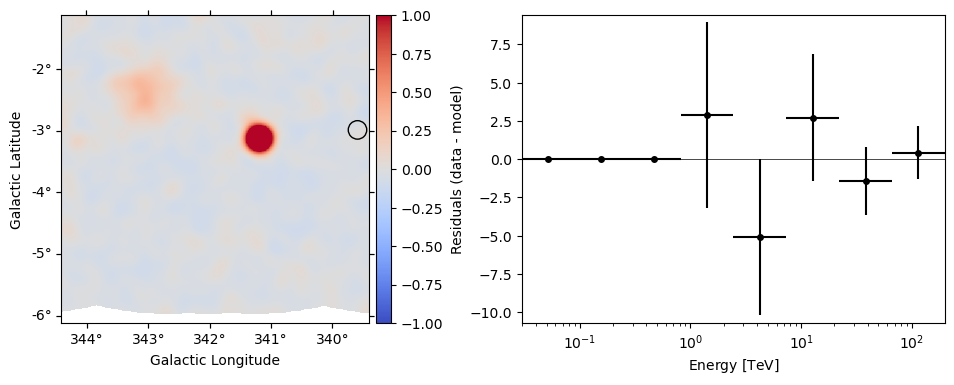

In [39]:
region = CircleSkyRegion(spatial_model.position.icrs, radius=0.15 * u.deg)
stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
)
plt.show()

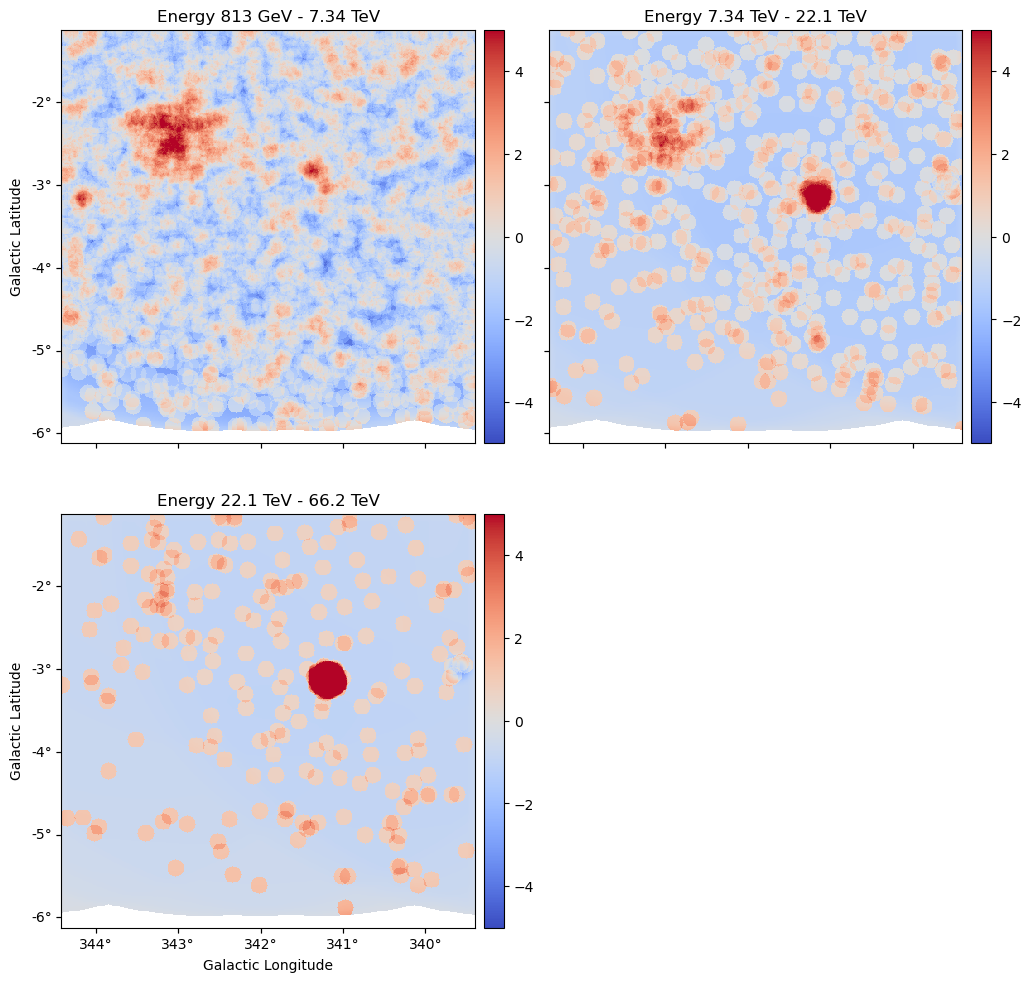

In [40]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.5, 1, 5, 10, 20, 100] * u.TeV,
)

result = estimator.run(stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 12), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)
plt.show()

## Open problems: 

1) Make a lightcurve of the source MRK 421 (ra, dec = 166.113808°, 38.2088329°) using the SDC data. Follow the 3D analysis using the reflected regions this time. Try to understand if the source experienced a spectral variation during time by creating a hardness-ratio plot using a soft and a hard band (up to you the choice of the energy ranges).
   
3) Try to create a small catalogue of the sources in this field. Run a source detection, and for each significant source, perform a 3D analysis. List your results! Open a catalogue of known gamma-ray sources and, when possible, associate the analyzed sources.

Some tips: 
- Set a significance threshold at 5 sigma and consider a minimum distance between detected sources of 0.15°;
- Assume a power-law spectral model for all the sources;
- Assume a gaussian morphology for all the sources (with ellipticity and angle fixed at the default values);
- Freeze the source position to speed up the fitting process;
- Assume the background is well known and take it from the IRF (i.e. use the `FoVBackgroundModel`);